(Q -1) Write a program for the SVD from scratch using eigen decompositon on the data matrix X. Use the top k singular vectors to reconstruct the data matrix X'. Plot the reconstruction error ||X − X'|| for k = 1,2,…

In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import tqdm

df = pd.read_csv(r"C:\Users\Rameshwar\Downloads\train.csv" , header=None)
# df = df.drop("label", axis=1)
# df = df.drop(df.index[0])
X = df.to_numpy(dtype=np.float32)


100%|██████████| 10/10 [00:39<00:00,  3.93s/it]


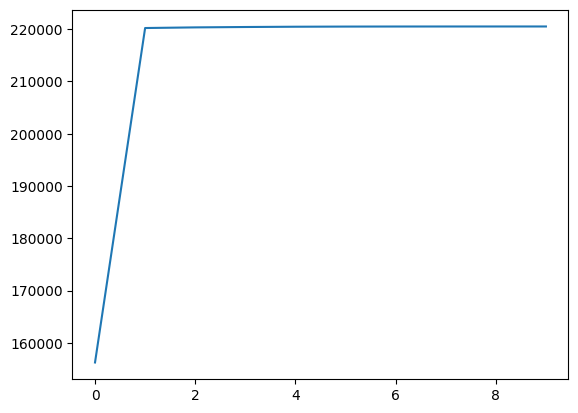

In [35]:
def SVD(X):

    Error = []
    Dominant_Singular_Vectors = []

    for k in tqdm.tqdm(range(10)):

        CovMat = np.dot(X.T, X) #Computing the Covariance Matrix

        w, v = np.linalg.eig(CovMat) # Computing the eigenvalues and eigenvectors of the covariance matrix.

        idx = np.argsort(w)[::-1] # Sort the eigenvalues and eigenvectors in descending order.
        w = w[idx]
        v = v[:, idx]

        U = v[:, :k] # Selecting the top k singular vectors.
        S = np.sqrt(w[:k])
        Vt = U.T

        X_hat = np.dot(U, np.dot(np.diag(S), Vt))
        # print(X_hat.shape)

        X_hat = np.ravel(X_hat)

        Y = np.zeros((60000, 256))
        Y = np.ravel(Y)

        max_len = max(len(Y),len(X_hat))
        max_array = np.zeros(max_len)

        for i in range(max_len):
            if i < len(Y):
                max_array[i]+=Y[i]
            if i < len(X_hat):
                max_array[i]+=X_hat[i]
        
        # X_hat = X_hat + Y

        X_hat = max_array.reshape((60000, 256))

        # print(A.shape)
        
        reconstruction_error_mod = np.linalg.norm(X - X_hat)

        Error.append(reconstruction_error_mod)
        Dominant_Singular_Vectors.append(k)

    return Error , Dominant_Singular_Vectors

Error, Dominant_SV = SVD(X)
plt.plot(Dominant_SV,Error)
plt.show()

In [41]:
import cv2
import numpy as np

def eight_point_algorithm(pts1, pts2):
  """Computes the essential matrix using the 8 point algorithm.

  Args:
    pts1: A numpy array of shape (N, 2) containing the feature points in the
      first image.
    pts2: A numpy array of shape (N, 2) containing the corresponding feature
      points in the second image.

  Returns:
    A numpy array of shape (3, 3) containing the essential matrix.
  """

  A = np.zeros((8, 9))
  for i in range(len(pts1)):
    x1, y1 = pts1[i]
    x2, y2 = pts2[i]
    A[i, :] = [x1 * x2, x1 * y2, x1, y1 * x2, y1 * y2, y1, x2, y2, 1]

  U, S, Vh = np.linalg.svd(A)
  F = Vh.T[:, -1].reshape(3, 3)
  F = F / F[2, 2]

  # Enforce the rank 2 constraint on F.
  U, S, Vh = np.linalg.svd(F)
  S[2] = 0
  F = np.matmul(U, np.diag(S), Vh)

  return F

def rectify_image(img, H):
  """Rectifies an image using the homography matrix H.

  Args:
    img: A numpy array of shape (H, W, 3) containing the image to be rectified.
    H: A numpy array of shape (3, 3) containing the homography matrix.

  Returns:
    A numpy array of shape (H, W, 3) containing the rectified image.
  """

  warped_img = cv2.warpPerspective(img, H, (img.shape[1], img.shape[0]))

  return warped_img

# Load the two images.
img1 = cv2.imread('left.jpeg', cv2.IMREAD_COLOR)
img2 = cv2.imread('right.jpeg', cv2.IMREAD_COLOR)

# Detect feature points in both images.
pts1 = cv2.ORB_create().detectAndCompute(img1, None)
pts2 = cv2.ORB_create().detectAndCompute(img2, None)

# Match the feature points between the two images.
matcher = cv2.DescriptorMatcher_create(cv2.DESCRIPTOR_MATCHER_BRUTEFORCE_HAMMING)
matches = matcher.match(pts1[0].descriptors, pts2[0].descriptors)

# Estimate the essential matrix using the 8 point algorithm.
F = eight_point_algorithm(pts1[0].keypoints, pts2[0].keypoints)

# Decompose the essential matrix into a rotation matrix and a translation vector.
K = np.eye(3)
R, T = cv2.decomposeEssentialMat(F)

# Rectify the two images using the rotation matrix and translation vector.
H1 = np.matmul(K, np.hstack((R, T)))
H2 = np.matmul(K, np.hstack((R, -R.T @ T)))

img1_rect = rectify_image(img1, H1)
img2_rect = rectify_image(img2, H2)

# Display the two rectified images.
cv2.imshow('Left Image (Rectified)', img1_rect)
cv2.imshow('Right Image (Rectified)', img2_rect)
cv2.waitKey(0)


AttributeError: 'tuple' object has no attribute 'descriptors'